In [1]:
# IMPORT LIBRARIES
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import functions
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.image as mpimg

In [32]:
# IMPORT SESSION DATA FROM "Portfolio" DATASET WHICH IS BROKEN DOWN BY SESSION
df_sessions = pd.read_csv('data/SB-County-County-Public-Portfolio-stations-report-01_01_20-12_31_24.csv', low_memory=False)
# print(df_sessions.head())
print(f"The dataframe has {df_sessions.shape[0]} and {df_sessions.shape[1]} columns")

The dataframe has 88919 and 30 columns


## Data Preparation

### Santa Barbara County "Portfolio" Data That Describes Individual E.V. Charging Sessions

In [33]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88919 entries, 0 to 88918
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   10-digit session UID         88919 non-null  int64  
 1   Session ID                   88919 non-null  object 
 2   Session start                88919 non-null  object 
 3   Session end                  88919 non-null  object 
 4   Session duration (minutes)   88758 non-null  float64
 5   Charging duration (minutes)  88919 non-null  float64
 6   Session idle (minutes)       88758 non-null  float64
 7   Estimated Completion Time    88919 non-null  object 
 8   kWh delivered                84516 non-null  float64
 9   MAX kW                       88439 non-null  float64
 10  AVG kW                       88439 non-null  float64
 11  SoC Start                    6134 non-null   object 
 12  SoC End                      16264 non-null  object 
 13  User            

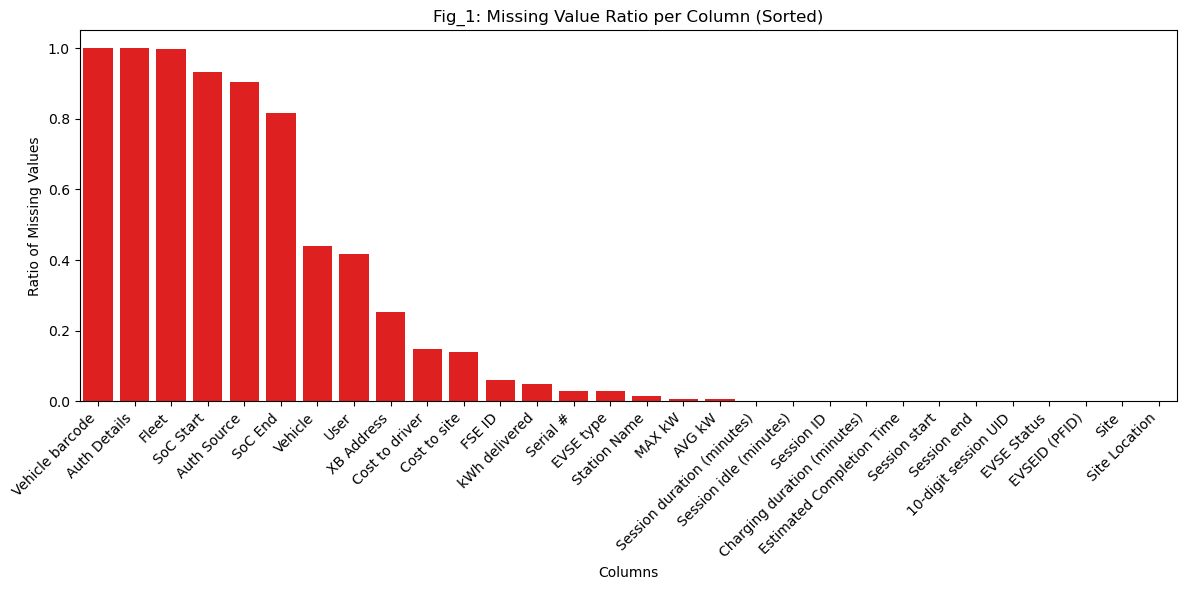

In [4]:
# Gets the mean of missing values in each column. Since True = 1 and False = 0 the mean tells us how much of the data is missing.
df_sessions_w_missing_values = df_sessions.isnull().mean().sort_values(ascending=False)

# Create the bar plot with Seaborn
plt.figure(figsize=(12, 6))
fig1 = sns.barplot(x=df_sessions_w_missing_values.index, y=df_sessions_w_missing_values.values, color='red')

# Customize the plot
plt.xlabel('Columns')
plt.ylabel('Ratio of Missing Values')
plt.title('Fig_1: Missing Value Ratio per Column (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
plt.savefig('images/sessions/Fig_1.jpg')

# Show the plot
plt.show()

### Missing Values Analysis

The features 'Auth Source', 'Vehicle barcode', 'Auth Details', 'Fleet', 'SoC Start','SoC End', 'Vehicle', 'User', 'XB Address' have over 40% missing values and will thus be removed from the dataframe. Additionally, the 'Session ID' feature is an identifier that won't likely help with our analysis and prediction efforts, so it is alse to be removed. We will keep the anonymous UID value, because it might help us spot and explain some outliers.

In [5]:
# Drop columns from the DataFrame
df_sessions = df_sessions.drop(['Auth Source', 'Vehicle barcode', 'Auth Details', 'Fleet', 'SoC Start', 
                               'SoC End', 'Vehicle', 'User', 'XB Address', 'Session ID'], axis=1)

In [6]:
# Basic Statistical Analysis
df_sessions.describe()

,10-digit session UID,Session duration (minutes),Charging duration (minutes),Session idle (minutes),kWh delivered,MAX kW,AVG kW,Cost to site,Cost to driver
count,8.891900e+04,88758.000000,88919.000000,88758.000000,84516.000000,88439.000000,88439.000000,76531.000000,75673.000000
mean,2.648512e+08,810.169037,122.860643,687.085473,11.409536,10.052329,6.417935,20.366966,2.700200
std,1.676411e+08,3682.511037,593.476016,3549.077786,14.028437,18.549601,13.213645,150.350882,57.206936
min,6.171300e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.925000
25%,6.437734e+07,15.172500,0.250000,0.930000,0.012000,0.000000,0.000000,0.030000,0.000000
50%,3.426163e+08,113.200000,53.470000,2.580000,6.236500,5.905000,1.583000,1.390000,0.342000
75%,4.086744e+08,265.665000,187.000000,109.765000,17.358500,6.632000,5.803000,3.755500,2.455000
max,4.585894e+08,436664.600000,140922.020000,436664.600000,119.160000,517.170000,98.995000,9419.469000,8803.390000


### Filtering out SB County Fleet Data to Focus on Public Usage

Based on the following spreadsheet provided by the S.B. County's 
Zero-Emission Vehicles and Mobility Planni Jerel Francisco our analysis is to focus on the public usage of the charging stations. 

: https://docs.google.com/spreadsheets/d/1xRGK_ZnoM93P0HDJcok5WfZFDcxvYETne-_3y1qC_dE/edit?pli=1&gid=0#gid=0r Road"
]0 Foster Road

In [8]:
# All Delta (type 3) Sites
df_sessions_delta = df_sessions.query("`EVSE type` == 'Delta DCFC 100kW'")

sites_to_include_for_webasto = [
    "SBAPCD",
    "SB CARP Lookout Park",
    "SB CARP South Via Real",
    "SB IV Embarcadero",
    "SB Jail",
    "SM PW 620 Foster Road"
]

# Apply both filters using query
df_sessions_webasto = df_sessions.query("Site in @sites_to_include_for_webasto and `EVSE type` == 'Webasto DX'")

# Concatenate the two dataframes
df_sessions = pd.concat([df_sessions_delta, df_sessions_webasto])

# Display site counts in the combined dataframe
df_sessions['Site'].value_counts()

SB Admin                  10238
SB Health Services         9684
SB Jail                    3674
SB CARP South Via Real     2791
SB IV Embarcadero          2523
SB CARP Lookout Park       1791
Name: Site, dtype: int64

In [9]:
df_sessions['EVSE type'].value_counts()

Delta DCFC 100kW    19922
Webasto DX          10779
Name: EVSE type, dtype: int64

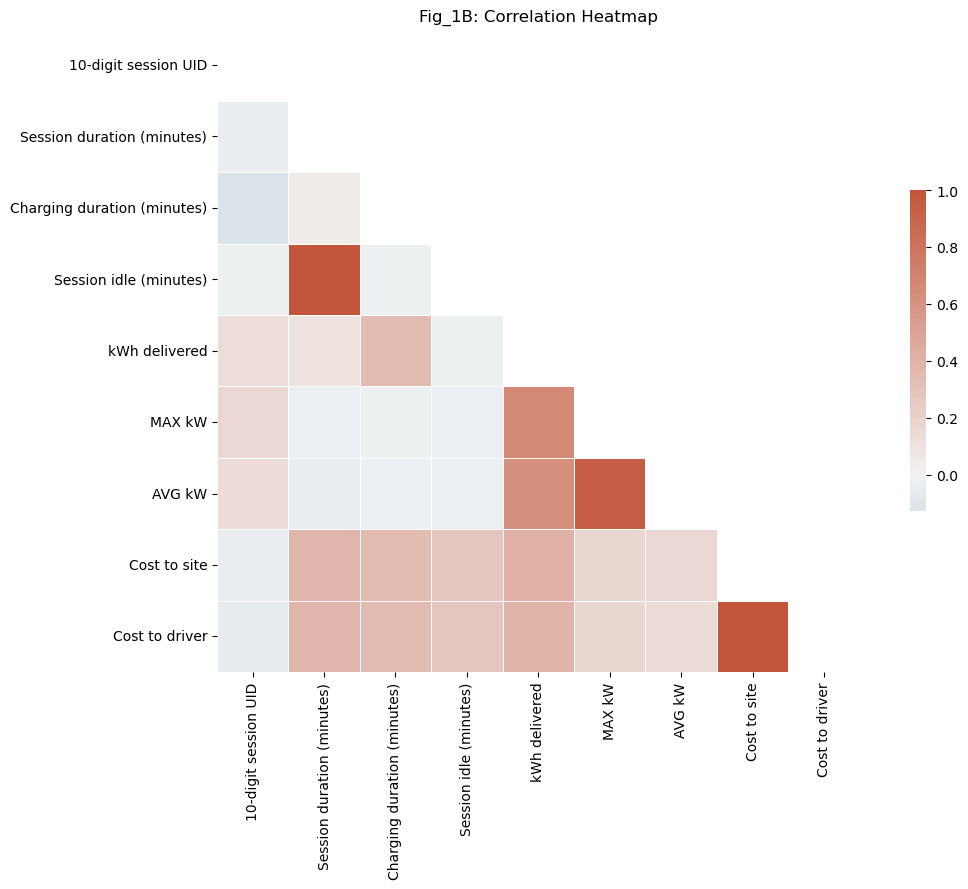

In [10]:
# Get correlations between the features 
df_sessions_corr = df_sessions.corr()
# print(df_sessions_corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_sessions_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_sessions_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Fig_1B: Correlation Heatmap')

# Adjust layout to prevent labels from being cropped off
plt.tight_layout()

# Save plot
plt.savefig('images/fig1B.jpg')

# Show the plot
plt.show()

In [11]:
# Top Correlations

# NOTE: I don't think this is useful as is but might be helpful if we want to filter down to some more useful correlations.

# Convert correlation matrix to a series for easier manipulation
corr_pairs = df_sessions_corr.unstack()

# Remove self-correlations (which are always 1)
corr_pairs = corr_pairs[corr_pairs < 1]

# Get absolute values for sorting (to include negative correlations)
corr_pairs_abs = corr_pairs.abs().sort_values(ascending=False)

# Get top 5 correlations (these will be the strongest positive and negative)
top_5_correlations = corr_pairs_abs.head(5)

# Display the results with their actual correlation values (not absolute)
for idx, (pair, _) in enumerate(top_5_correlations.items(), 1):
    feature1, feature2 = pair
    correlation = corr_pairs[pair]
    print(f"{idx}. {feature1} — {feature2}: {correlation:.4f}")

1. Session duration (minutes) — Session idle (minutes): 0.9982
2. Session idle (minutes) — Session duration (minutes): 0.9982
3. Cost to driver — Cost to site: 0.9913
4. Cost to site — Cost to driver: 0.9913
5. MAX kW — AVG kW: 0.9398


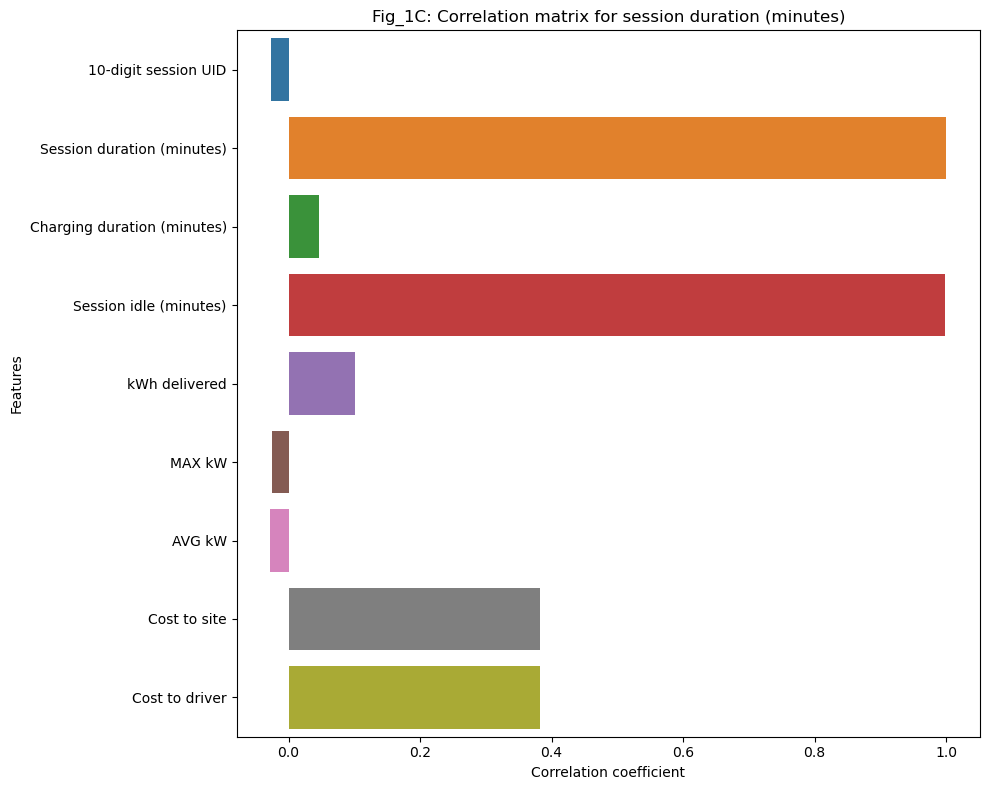

In [12]:
# Fig_1C: Correlation matrix for session duration (minutes)

# Get correlations between the features 
df_sessions_corr = df_sessions.corr()

# Get correlation matrix for AVG session duration (minutes)
df_sessions_corr_avg_sessions = df_sessions_corr['Session duration (minutes)']

# Seaborn plot for correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=df_sessions_corr_avg_sessions.values, y=df_sessions_corr_avg_sessions.index)
plt.title('Fig_1C: Correlation matrix for session duration (minutes)')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')

# Adjust layout to prevent labels from being cropped off
plt.tight_layout()

# Save plot
plt.savefig('images/sessions/Fig1_C.jpg')

# Show the plot
plt.show()

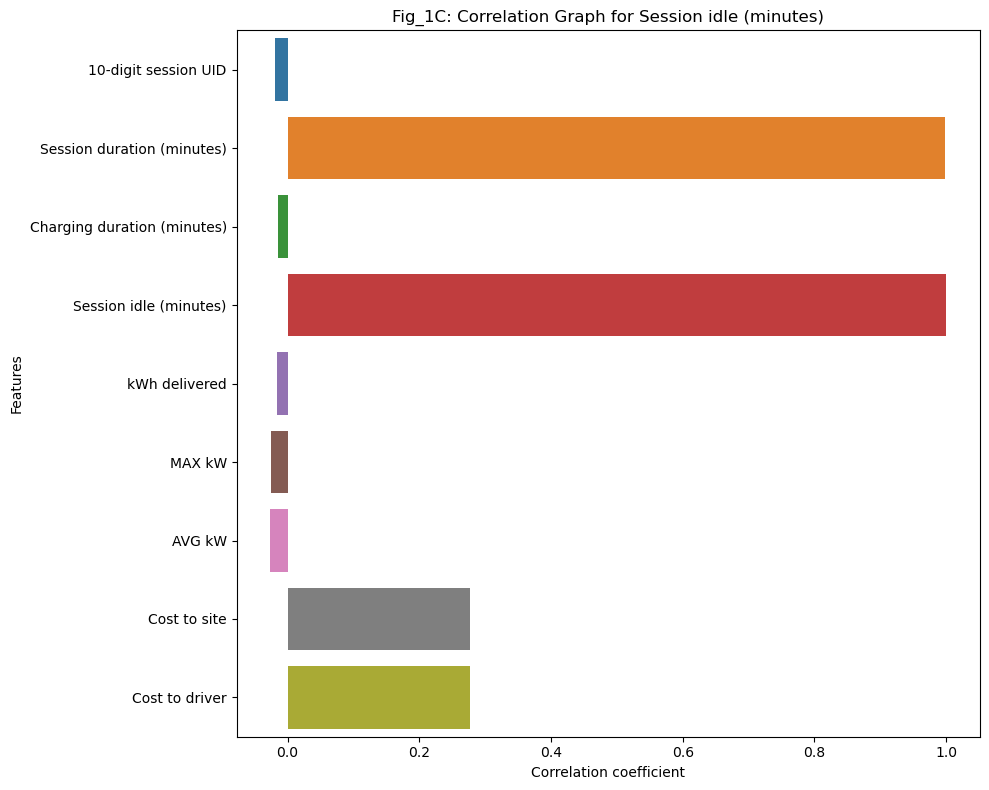

In [13]:
# Fig_1C: Correlation matrix for AVG session duration (minutes)

# Get correlations between the features 
df_sessions_corr = df_sessions.corr()

# Get correlation matrix for AVG session duration (minutes)
df_sessions_corr_avg_sessions = df_sessions_corr['Session idle (minutes)']

# Seaborn plot for correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=df_sessions_corr_avg_sessions.values, y=df_sessions_corr_avg_sessions.index)
plt.title('Fig_1C: Correlation Graph for Session idle (minutes)')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')

# Adjust layout to prevent labels from being cropped off
plt.tight_layout()

# Save plot
plt.savefig('images/sessions/Fig_1C.jpg')

# Show the plot
plt.show()

## Energy Delivered (kWh) vs Completed Sessions - Explore SB County Question 

### Analysing Sessions Data Set
report: https://colab.research.google.com/drive/1NAge1_GYw95EISVNFlWXOUP2JGTZAvxp#scrollTo=xRVDbcpiPBHQ

In [14]:
# Filtering out sessions that had no charging
df_sessions_session_completed = df_sessions[df_sessions['kWh delivered'] > 0.01]

print(f"Completed Sessions: {df_sessions_session_completed.shape[0]}")
print(f"All Sessions: {df_sessions.shape[0]}")
print(f"Non-completed Sessions: {df_sessions.shape[0] - df_sessions_session_completed.shape[0]}")

# Calculate completion percentage
completion_rate = (df_sessions_session_completed.shape[0] / df_sessions.shape[0]) * 100
print(f"Completion Rate: {completion_rate:.2f}%")

Completed Sessions: 19511
All Sessions: 30701
Non-completed Sessions: 11190
Completion Rate: 63.55%


In [15]:
# Calculate percentage of completed vs. non-completed sessions
completed_sessions = df_sessions_session_completed.shape[0]
all_sessions = df_sessions.shape[0]
non_completed_sessions = all_sessions - completed_sessions
completion_rate = (completed_sessions / all_sessions) * 100

print(f"Completed Sessions: {completed_sessions} ({completion_rate:.2f}%)")
print(f"Non-completed Sessions: {non_completed_sessions} ({100-completion_rate:.2f}%)")

# First, create your filtered DataFrame using a clear copy
zero_energy_sessions = df_sessions[df_sessions['kWh delivered'] <= 0.01].copy()

# Check for patterns in non-completed sessions
# Duration statistics
if 'Session duration (minutes)' in zero_energy_sessions.columns:
    print(f"\nNon-completed session duration statistics:")
    print(zero_energy_sessions['Session duration (minutes)'].describe())

# Vehicle type breakdown
if 'Vehicle' in zero_energy_sessions.columns:
    print(f"\nVehicle types in non-completed sessions:")
    print(zero_energy_sessions['Vehicle'].value_counts().head())

# Status breakdown
if 'EVSE Status' in zero_energy_sessions.columns:
    print(f"\nEVSE status in non-completed sessions:")
    print(zero_energy_sessions['EVSE Status'].value_counts())

# Time of day analysis
if 'Session start' in zero_energy_sessions.columns:
    zero_energy_sessions['Hour'] = pd.to_datetime(zero_energy_sessions['Session start']).dt.hour
    print(f"\nHourly distribution of non-completed sessions:")
    print(zero_energy_sessions['Hour'].value_counts().sort_index())


Completed Sessions: 19511 (63.55%)
Non-completed Sessions: 11190 (36.45%)

Non-completed session duration statistics:
count     8704.000000
mean        38.172653
std        318.558350
min          0.000000
25%          0.850000
50%          1.900000
75%          6.030000
max      21538.920000
Name: Session duration (minutes), dtype: float64

EVSE status in non-completed sessions:
FINISHED    8704
Name: EVSE Status, dtype: int64

Hourly distribution of non-completed sessions:
0      88
1      94
2      97
3      79
4     108
5     114
6     182
7     276
8     508
9     544
10    636
11    669
12    667
13    721
14    667
15    566
16    562
17    534
18    426
19    340
20    271
21    244
22    213
23     98
Name: Hour, dtype: int64


In [16]:
# Create filtered DataFrame for completed sessions
completed_energy_sessions = df_sessions[df_sessions['kWh delivered'] > 0.01].copy()

# Duration statistics
if 'Session duration (minutes)' in completed_energy_sessions.columns:
    print(f"\nCompleted session duration statistics:")
    print(completed_energy_sessions['Session duration (minutes)'].describe())

# Vehicle type breakdown
if 'Vehicle' in completed_energy_sessions.columns:
    print(f"\nVehicle types in completed sessions:")
    print(completed_energy_sessions['Vehicle'].value_counts().head())

# Status breakdown
if 'EVSE Status' in completed_energy_sessions.columns:
    print(f"\nEVSE status in completed sessions:")
    print(completed_energy_sessions['EVSE Status'].value_counts())

# Time of day analysis
if 'Session start' in completed_energy_sessions.columns:
    completed_energy_sessions['Hour'] = pd.to_datetime(completed_energy_sessions['Session start']).dt.hour
    print(f"\nHourly distribution of completed sessions:")
    print(completed_energy_sessions['Hour'].value_counts().sort_index())

# Additional insights for completed sessions
if 'kWh delivered' in completed_energy_sessions.columns:
    print(f"\nEnergy delivery statistics (kWh):")
    print(completed_energy_sessions['kWh delivered'].describe())

# Analyze charging efficiency
if all(col in completed_energy_sessions.columns for col in ['Charging duration (minutes)', 'kWh delivered']):
    completed_energy_sessions['kWh per minute'] = completed_energy_sessions['kWh delivered'] / completed_energy_sessions['Charging duration (minutes)']
    print(f"\nCharging efficiency statistics (kWh per minute):")
    print(completed_energy_sessions['kWh per minute'].describe())



Completed session duration statistics:
count    19447.000000
mean       103.233874
std        161.995725
min          0.000000
25%         33.850000
50%         62.630000
75%        142.785000
max      11289.670000
Name: Session duration (minutes), dtype: float64

EVSE status in completed sessions:
FINISHED    19511
Name: EVSE Status, dtype: int64

Hourly distribution of completed sessions:
0      183
1      192
2      277
3      236
4      275
5      394
6      938
7      806
8     1350
9     1247
10    1607
11    1499
12    1530
13    1445
14    1280
15    1106
16    1047
17    1070
18     726
19     673
20     579
21     457
22     328
23     266
Name: Hour, dtype: int64

Energy delivery statistics (kWh):
count    19511.000000
mean        21.625352
std         17.486902
min          0.011000
25%          7.500000
50%         17.480000
75%         32.740000
max        119.160000
Name: kWh delivered, dtype: float64

Charging efficiency statistics (kWh per minute):
count    1.951100e+

In [17]:
# Compare idle time between completed and non-completed sessions
if 'Session idle (minutes)' in df_sessions.columns:
    print("\nIdle time comparison:")
    print(f"Average idle time for completed sessions: {completed_energy_sessions['Session idle (minutes)'].mean():.2f} minutes")
    print(f"Average idle time for non-completed sessions: {zero_energy_sessions['Session idle (minutes)'].mean():.2f} minutes")

# Compare by location
if 'Site Location' in df_sessions.columns:
    completed_location_counts = completed_energy_sessions['Site Location'].value_counts()
    non_completed_location_counts = zero_energy_sessions['Site Location'].value_counts()
    
    total_by_location = df_sessions['Site Location'].value_counts()
    
    # Calculate completion rate by location
    print("\nTop locations by completion rate:")
    for location in total_by_location.index[:5]:
        completed = completed_location_counts.get(location, 0)
        total = total_by_location.get(location)
        rate = (completed / total) * 100 if total > 0 else 0
        print(f"{location}: {rate:.2f}% completion rate ({completed}/{total})")


Idle time comparison:
Average idle time for completed sessions: 22.90 minutes
Average idle time for non-completed sessions: 36.35 minutes

Top locations by completion rate:
105 E. Anapamu St, Santa Barbara, CA 93101: 52.92% completion rate (5418/10238)
315 Camino del Remedio, Santa Barbara, CA  93110: 63.51% completion rate (6150/9684)
4430 Calle Real, Santa Barbara, CA 93110: 86.39% completion rate (3174/3674)
6728 Via Real, Carpinteria, CA 93013: 68.94% completion rate (1924/2791)
881 Embarcadero del Mar, Isla Vista, CA 93117: 71.78% completion rate (1811/2523)


### Context: County has a 4 hour charging policy. 
Price increases per minute to stay plugged in 
#### 
Hypothesis: Average Session duration should be around 4 hours
Average Charging duration should be much lower than 4 hours 


Number of public charging sessions that are 4 hours or longer: 1856 (6.05%)
Number of public charging sessions: 30701


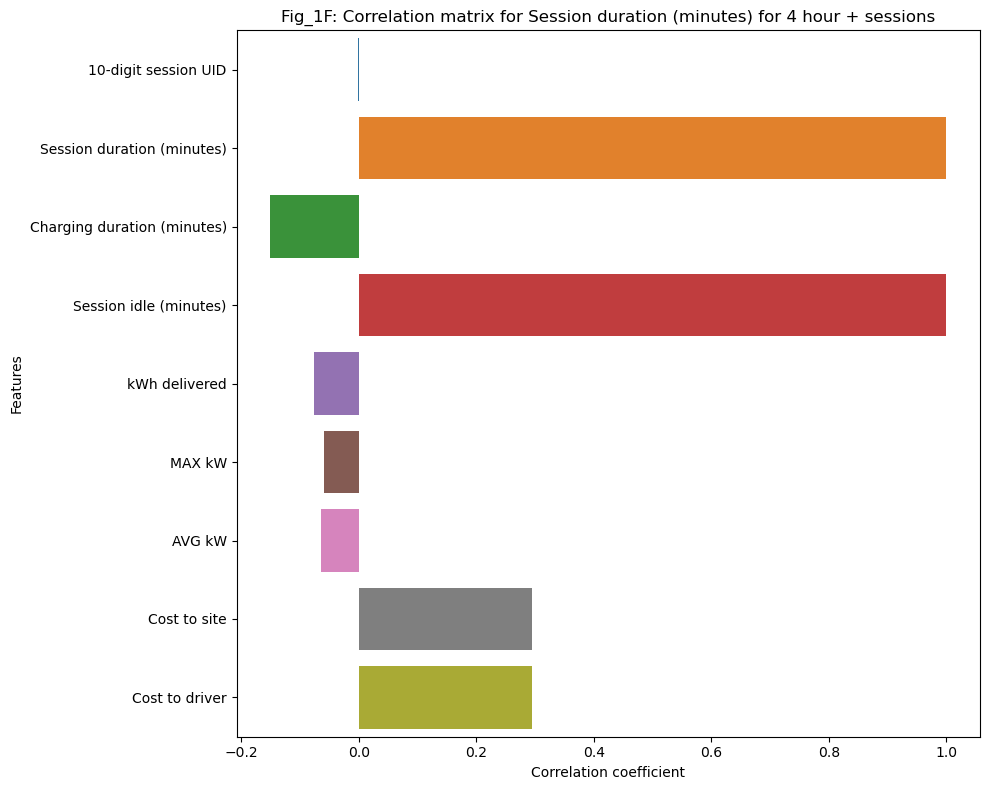

In [26]:
# Fig_1F: Correlation matrix for sessions longer than 4 hours (180 minutes)
# Get long sessions
long_sessions = df_sessions[df_sessions['Session duration (minutes)'] > 240]
long_sessions_percentage = round((long_sessions.shape[0]/df_sessions.shape[0])*100, 2)
print(f"Number of public charging sessions that are 4 hours or longer: {long_sessions.shape[0]} ({long_sessions_percentage}%)")
print(f"Number of public charging sessions: {df_sessions.shape[0]}")
# Get correlations between the features 
long_sessions_corr = long_sessions.corr()

# Get correlation matrix for AVG session duration (minutes)
long_sessions_corr_mtx = long_sessions_corr['Session duration (minutes)']

# Seaborn plot for correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=long_sessions_corr_mtx.values, y=long_sessions_corr_mtx.index)
plt.title('Fig_1F: Correlation matrix for Session duration (minutes) for 4 hour + sessions')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')

# Adjust layout to prevent labels from being cropped off
plt.tight_layout()

# Save plot
plt.savefig('images/plots/fig1F.jpg')

# Show the plot
plt.show()

# 

In [27]:
df_sessions['EVSE type'].value_counts()

Delta DCFC 100kW    19922
Webasto DX          10779
Name: EVSE type, dtype: int64

### When EVSE Type is Webasto and from Public Sites - Average Session Duration (total time EV Plugged into station) vs Average Charging Duration (total time EV: receiving electrons) ?

How long are the charging sessions? - By Level 2 vs Level 3 (Column name: EVSE Type)?
 
How long are the session durations? By Level 2 vs Level?
 3
How long is the charging duration ? by Level 2 vs Leve?
l 3
Level 2: Webasto 
Level 3: Delta 


In [28]:
# Filter by Level 2 charging method and Describe statistics
df_sessions_lvl2 = df_sessions[df_sessions['EVSE type'] == 'Webasto DX'].copy()
stats_df_webasto = df_sessions_lvl2.describe()
stats_df_webasto.to_csv('webasto_dx_statistics.csv')
stats_df_webasto

,10-digit session UID,Session duration (minutes),Charging duration (minutes),Session idle (minutes),kWh delivered,MAX kW,AVG kW,Cost to site,Cost to driver
count,1.077900e+04,10754.000000,10779.000000,10754.000000,10209.000000,10779.000000,10779.000000,9345.000000,9345.000000
mean,2.030301e+08,136.950215,98.945139,37.775029,8.341006,3.920709,3.116377,2.757433,2.743625
std,1.719700e+08,170.009973,101.871647,136.861593,9.475541,2.904308,2.695593,7.577707,7.601730
min,9.553001e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.759445e+07,22.397500,0.630000,0.660000,0.064000,1.626500,0.076000,0.183000,0.164000
50%,1.975380e+08,109.050000,73.750000,1.770000,5.779000,3.400000,2.897000,1.197000,1.182000
75%,3.861380e+08,212.792500,177.265000,29.500000,12.142000,6.630000,5.813500,2.550000,2.510000
max,4.585667e+08,6936.880000,786.500000,6936.880000,72.295000,8.434000,8.119000,285.112000,285.112000


In [29]:
# Filter by Level 3 charging method and Describe statistics
df_sessions_lvl3 = df_sessions[df_sessions['EVSE type'] == 'Delta DCFC 100kW'].copy()
stats_df_delta = df_sessions_lvl3.describe()
stats_df_delta.to_csv('delta_statistics.csv')
stats_df_delta

,10-digit session UID,Session duration (minutes),Charging duration (minutes),Session idle (minutes),kWh delivered,MAX kW,AVG kW,Cost to site,Cost to driver
count,1.992200e+04,19883.000000,19922.000000,19883.000000,18006.000000,19922.000000,19922.000000,15258.000000,15257.000000
mean,3.113333e+08,93.107326,26.133876,66.922144,18.703778,30.587934,20.485755,3.210200,3.088248
std,1.631180e+08,1516.036138,31.011738,1516.541035,19.947959,30.923233,22.330353,6.872012,6.877567
min,6.136901e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.375517e+08,2.350000,0.000000,1.330000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.955439e+08,25.250000,16.435000,1.900000,14.008000,32.725000,16.441000,2.555500,2.386000
75%,4.235476e+08,54.365000,45.000000,3.400000,33.367500,53.770000,37.761000,5.200000,5.060000
max,4.585894e+08,117681.100000,347.880000,117681.100000,119.160000,517.170000,98.995000,634.279000,634.279000
